# Linear Function Approximation 

In [170]:
import numpy as np
import easy21env as easy21
import easy21_table
import pandas as pd
import easy21_table
from numba import njit
from numba import jit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
%matplotlib inline  
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 10)

# Step size
discount_factor = 1.0 
sarsa_lambda = 0.4

N0 = 1000

dealer_bins = ((1, 2, 3, 4), (4, 5, 6, 7), (7, 8, 9, 10)) 
player_bins = ((1, 2, 3, 4, 5, 6), 
               (4, 5, 6, 7, 9), 
               (7, 8, 9, 10, 11, 12), 
               (10, 11, 12, 13, 14, 15),
               (13, 14, 15, 16, 17, 18), 
               (16, 17, 18, 19, 20, 21)) 
state_len = len(dealer_bins) * len(player_bins) * 2

Populating the interactive namespace from numpy and matplotlib


In [157]:
# Read in optimal q value determined from monte carlo control.
q_optimal = pickle.load(open( "q_optimal.p", "rb" ))

In [158]:
theta = np.zeros(state_len) 

In [159]:
#@njit
def feature(dealer_score, player_score, action):
    feature_vec = np.ones((len(dealer_bins), len(player_bins), 2))
    idx = 0
    for i, dealer_bin in enumerate(dealer_bins):
        feature_vec[i, :, :] = 0.0 if dealer_score not in dealer_bin else feature_vec[i, :, :]
    for i, player_bin in enumerate(player_bins):
        feature_vec[:, i, :] = 0.0 if player_score not in player_bin else feature_vec[:, i, :]
    feature_vec[:, :, 1] = 0.0 if action == 0 else feature_vec[:, :, 1]
    feature_vec[:, :, 0] = 0.0 if action == 1 else feature_vec[:, :, 0]
    return feature_vec.flatten()

def calc_q(theta):
    q = np.zeros((10, 21, 2))
    for i in range(1, 11):
        for j in range(1, 22):
            for k in range(0, 2):
                q[i - 1, j - 1, k] = get_approx_q(theta, i, j, k)
    return q 

#@njit
def test_feature():
    dealer_score = 4
    player_score = 14
    action = 1
    #print(np.reshape(feature(dealer_score, player_score, action), (len(dealer_bins), len(player_bins), 2)))
    
test_feature()

#@njit
def get_approx_q(theta, dealer_score, player_score, action):
    my_feature = feature(dealer_score, player_score, action)
    approx_q = np.sum(theta * my_feature)
    return approx_q

In [160]:

# Epsilon greedy policy
#@njit
def choose_action(epsilon, dealer_score, player_score):
    if random.random() < epsilon: 
        action = 1 if random.random() > 0.5  else 0 
    else:
        q_action_0 = get_approx_q(theta, dealer_score, player_score, 0)
        q_action_1 = get_approx_q(theta, dealer_score, player_score, 1)
        if q_action_0 > q_action_1:
            action = 0
        else:
            action = 1
    return action

#@njit
def episode(theta, sarsa_lambda, count):
    #e = easy21_table.create_e()
    e = np.zeros(state_len)
    theta_list = np.zeros((count, state_len))
    for i in range(count):
        theta_list[i, :] = theta
        e = easy21_table.reset_e(e)
        player_card_t0 = easy21.take(0)
        dealer_card_t0 = easy21.take(0)
        player_score_t0 = player_card_t0[0]
        dealer_score_t0 = dealer_card_t0[0]
        epsilon = 0.05
        action_t0 =  choose_action(epsilon, dealer_score_t0, player_score_t0)
        states = []
        terminal = False
        while terminal == False:
            step_size = 0.01
            states.append((dealer_score_t0, player_score_t0, action_t0))
            dealer_card_t1, player_score_t1, terminal, reward = easy21.step(dealer_card_t0, player_score_t0, action_t0)
            dealer_score_t1 = dealer_card_t1[0]
            q_t0 = get_approx_q(theta, dealer_score_t0, player_score_t0, action_t0)
            e = discount_factor * sarsa_lambda * e + feature(dealer_score_t0, player_score_t0, action_t0)
            if terminal:
                error = reward - q_t0
            else:
                action_t1 = choose_action(epsilon, dealer_score_t1, player_score_t1)
                q_t1 = get_approx_q(theta, dealer_score_t1, player_score_t1, action_t1)
                error = reward + discount_factor * q_t1 - q_t0
            theta += step_size * error * e
            if not terminal:
                dealer_card_t0 = dealer_card_t1
                player_score_t0 = player_score_t1 
                action_t0 = action_t1 
    return theta, theta_list

In [161]:
theta, theta_list = episode(theta, sarsa_lambda, 10000)

In [162]:
q = calc_q(theta)

In [163]:
z = np.zeros((30, 11))
x, y = np.meshgrid(range(1,22), range(1,11))

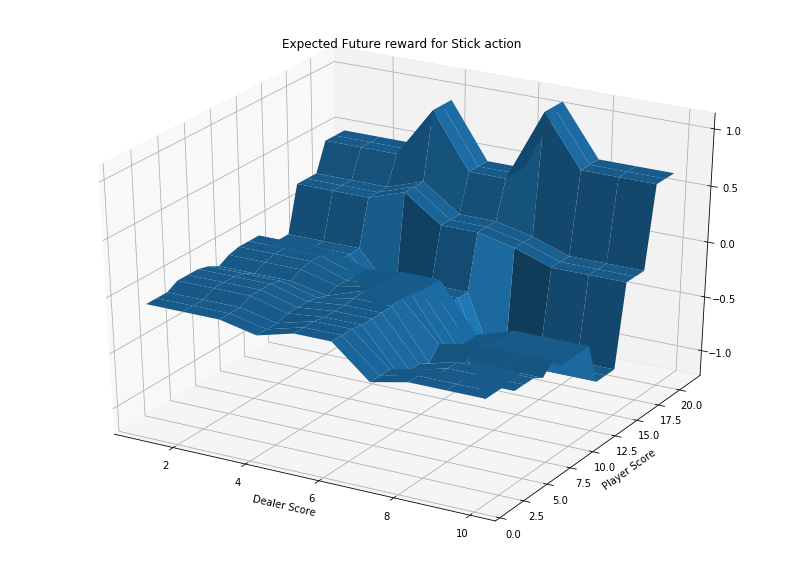

In [164]:
fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')
ax3d.plot_surface(y, x , q[:,:,0])
plt.xlabel('Dealer Score')
plt.ylabel('Player Score')
plt.title('Expected Future reward for Stick action')

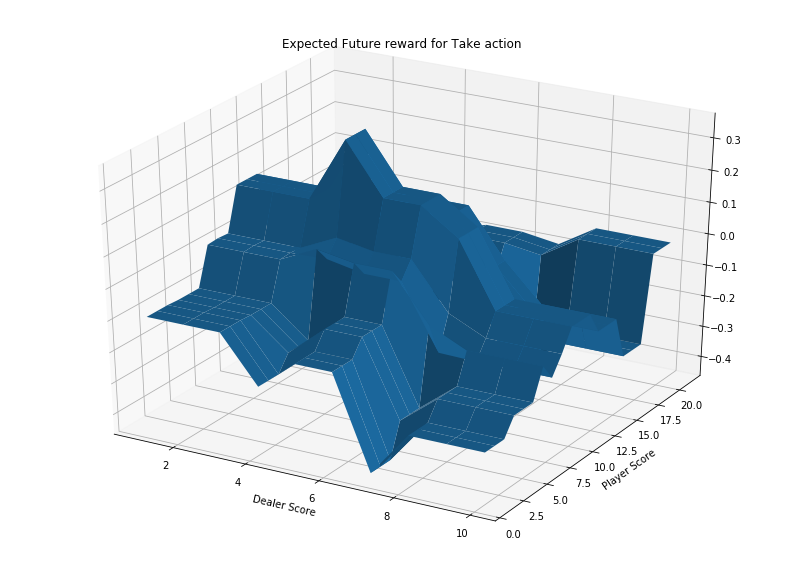

In [165]:
fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')
ax3d.plot_surface(y, x , q[:,:,1])
plt.xlabel('Dealer Score')
plt.ylabel('Player Score')
plt.title('Expected Future reward for Take action')

In [166]:
sarsa_lambda_values = np.arange(0.0, 1.1, 0.1)
mse = np.zeros(len(sarsa_lambda_values))
mse_list = []
for i, sarsa_lambda in enumerate(sarsa_lambda_values):
    theta = np.zeros(state_len) 
    theta, theta_list = episode(theta, sarsa_lambda, 1000)
    if sarsa_lambda == 0.0 or sarsa_lambda == 1.0:
        mse_list.append(list(map(lambda x:  ((q_optimal - np.max(calc_q(x), axis=2)) ** 2).mean(), theta_list)))
    q = calc_q(theta)
    max_q = np.max(q, axis=2)
    mse[i] = ((q_optimal - max_q) ** 2).mean()

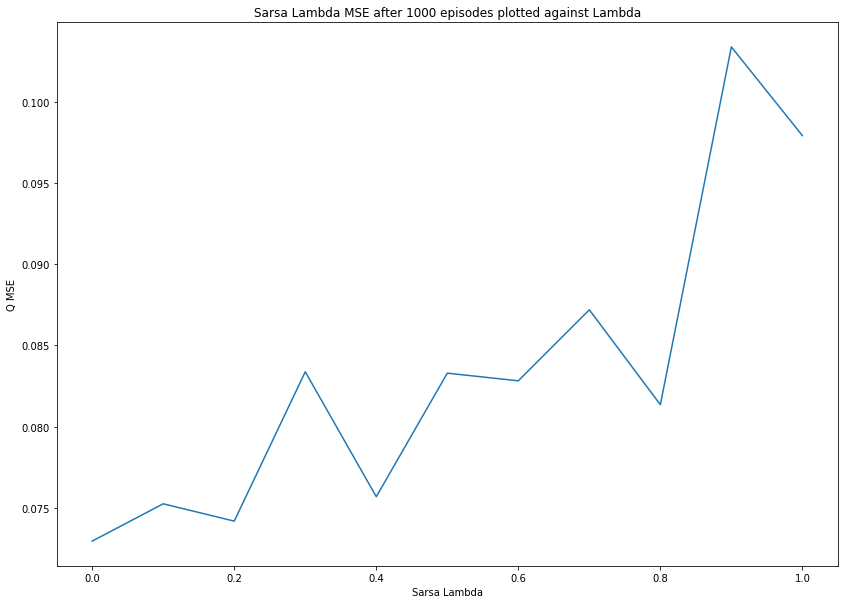

In [167]:
plt.plot(sarsa_lambda_values, mse)
plt.xlabel('Sarsa Lambda')
plt.ylabel('Q MSE')
plt.title('Sarsa Lambda MSE after 1000 episodes plotted against Lambda')

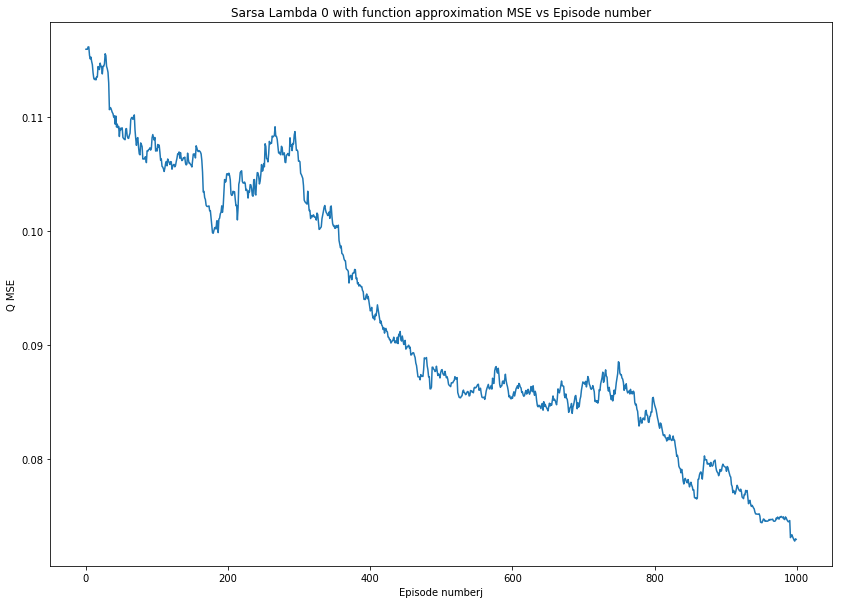

In [168]:
plt.plot(mse_list[0])
plt.xlabel('Episode numberj')
plt.ylabel('Q MSE')
plt.title('Sarsa Lambda 0 with function approximation MSE vs Episode number')

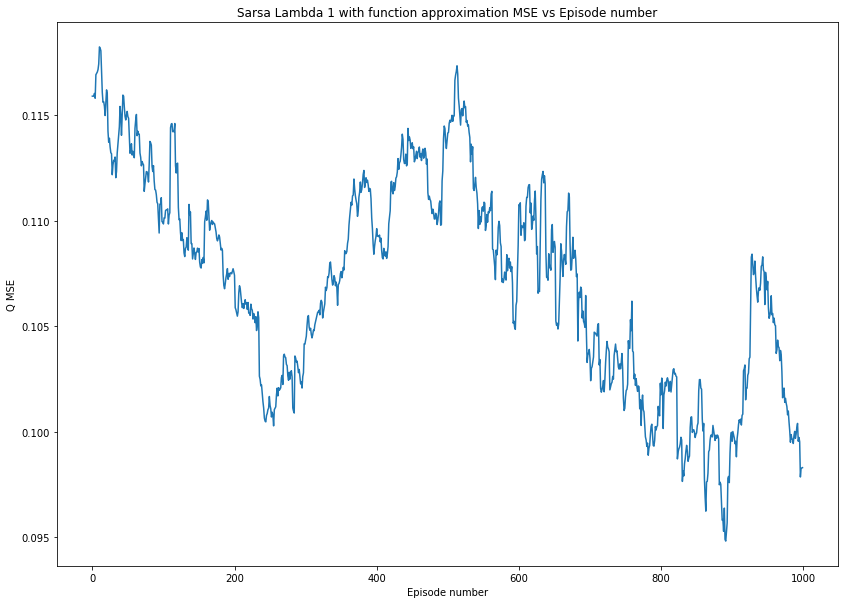

In [169]:
plt.plot(mse_list[1])
plt.xlabel('Episode number')
plt.ylabel('Q MSE')
plt.title('Sarsa Lambda 1 with function approximation MSE vs Episode number')